In [101]:
import pandas as pd

import engarde.decorators as ed

def read(file):
    df = ((pd.read_excel(file, skiprows=2, usecols=columns))
          .rename(columns, axis=1)
          .pipe(str_to_numeric, ['fat', 'carbs', 'fiber', 'protein'])
          .pipe(str_to_lower, ['name', 'category'])
          .assign(net_carbs = lambda df: df.carbs - df.fiber)
          .dropna(how='any'))
    return df

columns = {
    'Name': 'name',
    'Kategorie': 'category',
    'Bezugseinheit': 'units',
    'Energie, Kalorien': 'calories',
    'Fett, total (g)': 'fat',
    'Kohlenhydrate, verfügbar (g)': 'carbs',
    'Nahrungsfasern (g)': 'fiber',
    'Protein (g)': 'protein'
}

def str_to_numeric(df, columns):
    """
    Convert string columns to numeric.
    """
    df = df.copy()
    def converter(col):
        return pd.to_numeric(col, errors='coerce')

    df[columns] = df[columns].apply(converter)
    return df

def str_to_lower(df, columns):
    """
    Convert string columns to lower-case.
    """
    df = df.copy()
    def converter(col):
        return col.str.lower()
    
    df[columns] = df[columns].apply(converter)
    return df


data = 'Schweizer-Nährwertdatenbank-V6.1.xlsx'

foods = read(data)
foods.head()

,name,category,units,calories,fat,carbs,fiber,protein,net_carbs
0,agar agar,verschiedenes/gelier- und bindemittel,pro 100g essbarer Anteil,160,0.2,0.0,74.1,2.4,-74.1
1,agavensirup,süssigkeiten/zucker und süssstoffe,pro 100g essbarer Anteil,293,0.0,73.1,0.0,0.2,73.1
2,"älplermagronen, zubereitet",gerichte/sonstige salzige/rezente gerichte,pro 100g essbarer Anteil,183,9.0,18.6,1.7,6.0,16.9
3,"amaranth, samen, gekocht (ohne zugabe von fett...","getreideprodukte, hülsenfrüchte und kartoffeln...",pro 100g essbarer Anteil,126,2.4,19.1,3.7,5.3,15.4
4,"amaranth, samen, roh","getreideprodukte, hülsenfrüchte und kartoffeln...",pro 100g essbarer Anteil,376,7.0,56.8,11.0,15.8,45.8


Find items

In [110]:
foods.loc[foods.name.str.contains('tofu')]

,name,category,units,calories,fat,carbs,fiber,protein,net_carbs
907,tofu,fleischersatzprodukte,pro 100g essbarer Anteil,81,4.8,0.7,1.2,8.1,-0.5


Build my dataset with my foods 

In [111]:
def keep_myfoods(data):
    df = (data.loc[data.name.isin(my_foods)]
          .pipe(rename_foods))
    return df

my_foods = {
    'hühnerei, ganz, roh': 'egg',
    'olivenöl': 'olive oil',
    'spinat, roh': 'spinach', 
    'champignon, roh': 'mushrooms',
    'blattsalat (durchschnitt), roh': 'lettuce',
    'peperoni, rot, roh': 'red pepper',
    'avocado, roh': 'avocado',
    'tofu': 'tofu'
}

def rename_foods(df):
    df = df.copy()
    df['name'] = df['name'].map(my_foods)
    return df

myfoods = keep_myfoods(foods)
myfoods 

,name,category,units,calories,fat,carbs,fiber,protein,net_carbs
33,avocado,"gemüse/gemüse frisch;nüsse, samen und ölfrüchte",pro 100g essbarer Anteil,144,14.2,0.8,3.0,1.8,-2.2
139,mushrooms,gemüse/pilze,pro 100g essbarer Anteil,25,0.3,1.1,1.9,3.7,-0.8
316,egg,eier,pro 100g essbarer Anteil,142,10.3,0.3,0.0,11.9,0.3
563,olive oil,fette und öle/öle,pro 100 ml,810,90.0,0.0,0.0,0.0,0.0
583,red pepper,gemüse/gemüse frisch,pro 100g essbarer Anteil,32,0.4,5.2,2.0,0.9,3.2
865,spinach,gemüse/gemüse frisch,pro 100g essbarer Anteil,23,0.4,0.8,2.6,2.7,-1.8
907,tofu,fleischersatzprodukte,pro 100g essbarer Anteil,81,4.8,0.7,1.2,8.1,-0.5


In [227]:
def meal_nutrients(foods, portions):
    
    pieces = []
    nutrients = ['calories', 'fat', 'protein', 'net_carbs']
    for ingredient, portion in portions.items():
        nuts = foods.loc[foods.name == ingredient, nutrients] * portion
        pieces.append(nuts)
        
    nutrients = pd.concat(pieces)
    nutrients[nutrients < 0] = 0
    return nutrients.


snack = {
    'egg': 2,
    'olive oil': 0.2,
    'spinach': 0.4,
    'mushrooms': 0.5
}

lunch = {
    'lettuce': 1.5,
    'avocado': 1.5,
    'olive oil': 0.2,
    'red pepper': 1,
    'tofu': 2.5
}

snack_nuts = meal_nutrients(myfoods, snack)
lunch_nuts = meal_nutrients(myfoods, lunch)

In [231]:
lunch_nuts.sum()

calories     612.50
fat           51.70
protein       23.85
net_carbs      3.20
dtype: float64

Make a plot

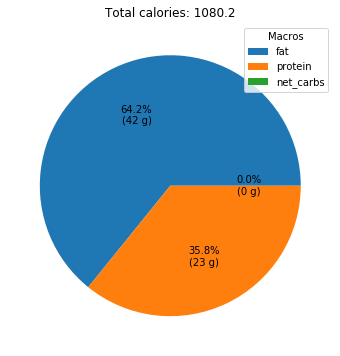

In [226]:
import matplotlib.pyplot as plt

data = snack_nuts + lunch_nuts

calories = data[0]
macros = data[1:]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)


fix, ax = plt.subplots(figsize=(6, 6))

wedges, text, autotext = ax.pie(macros, autopct=lambda pct: func(pct, nuts))

ax.legend(wedges, macros.index, title='Macros')

ax.set_title(f'Total calories: {calories}');